# LDA Topic Modeling 실습

In [1]:
# 예제 데이터

D = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]


> - LDA는 모든 단어를 하나씩 봐야하기 때문에 사실상 numpy를 사용하는 메리트가 없으므로 그냥 list로 구현하기로 한다.  
> - numpy는 행렬 연산에 좋다.

In [2]:
# 정규화 - 영어를 소문자로 통일

_D = list()
V = list()
for d in D: # M
    N = list() # N ㅌ {1, ... , M}
    for t in d:
        V.append(t.lower())
        N.append(t.lower())
    _D.append(N)

V = list(set(V))

In [3]:
# 아래 코드는 위의 _D를 이중 컴프리헨션으로 구현하는 방법

# _D = list(list(t.lower() for t in d)
#          for d in D)

In [4]:
# 결과 확인

_D

[['hadoop', 'big data', 'hbase', 'java', 'spark', 'storm', 'cassandra'],
 ['nosql', 'mongodb', 'cassandra', 'hbase', 'postgres'],
 ['python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas'],
 ['r', 'python', 'statistics', 'regression', 'probability'],
 ['machine learning', 'regression', 'decision trees', 'libsvm'],
 ['python', 'r', 'java', 'c++', 'haskell', 'programming languages'],
 ['statistics', 'probability', 'mathematics', 'theory'],
 ['machine learning', 'scikit-learn', 'mahout', 'neural networks'],
 ['neural networks', 'deep learning', 'big data', 'artificial intelligence'],
 ['hadoop', 'java', 'mapreduce', 'big data'],
 ['statistics', 'r', 'statsmodels'],
 ['c++', 'deep learning', 'artificial intelligence', 'probability'],
 ['pandas', 'r', 'python'],
 ['databases', 'hbase', 'postgres', 'mysql', 'mongodb'],
 ['libsvm', 'regression', 'support vector machines']]

> - 정규화는 소문자까지만 하기로 한다.
> - '-'로 연결된 단어는 나누지 않고 하나의 단어로 보기로 한다.

In [5]:
from random import seed, randrange

seed(0)

K = 3 # 토픽의 수
a = 0.1
b = 0.1
M = len(_D)
N = len(V)

# (D, V) # i번째 문서의, l번째 단어의 토픽 할당
Z = list(list(randrange(K) 
              for l in range(len(D[i])))
     for i in range(M))

# (K, V) # 토픽별 단어의 분포; Topic-Term Distribution
Phi = list(list(0 for _ in range(N))
            for _ in range(K))

# (D, K) # 문서별 토픽의 분포; Document-Topic Doc distribution
Theta = list(list(0 for _ in range(K))
            for _ in range(M))

# n_i_jr = Phi, Theta
# i번째 토픽의 j번째 문서에서 r이라는 단어가 몇 번 나왔는지.
for i in range(len(Z)):
    for j in range(len(Z[i])):
        k = Z[i][j] # topic
        termidx = V.index(_D[i][j]) 
        Phi[k][termidx] += 1
        Theta[i][k] += 1

> - 문서, 단어, 토픽의 분포를 Theta, Phi로 만들었다.  
> - 단어에 대한 토픽 할당은 임의의 초기값을 준다.(randrange 이용함)

In [6]:
def topic_likelihood(k, b, t):
    return (Phi[k][t]+b) / (sum(Phi[k])+b)
#                            => 시간 오래 걸림
def doc_likelihood(k, a, d):
    return Theta[d][k] + a
  
def gibbs_sampling(a, b, t, d):
    candidates = list(0.0 for _ in range(K))
    for k in range(K):
        candidates[k] = \
        topic_likelihood(k, b, t) * \
        doc_likelihood(k, a, d)
    return choices(range(K), candidates)[0]

> - 단어가 어떤 토픽일 확률 x 문서가 어떤 토픽일 확률
> - 깁스 샘플링은 데이터를 개별 샘플링해서 합치면 전체 데이터를 샘플링한 것과 같을 것이라는 아이디어이다.

#### 아래는 choices를 어떻게 쓰는지 설명하느라 쓴 코드

In [7]:
from collections import defaultdict
result = defaultdict(int)
for _ in range(1000):
    result[randrange(K)] += 1

In [8]:
# randrange는 동일한 비율로 랜덤하게 반환한다.

result

defaultdict(int, {1: 337, 0: 346, 2: 317})

In [9]:
from random import choices
result = defaultdict(int)
for _ in range(2000):
    result[choices(range(K), 
                 [0.1, 0.8, 0.1])[0]] += 1

In [10]:
# choices는 사용자가 랜덤 비율을 정할 수 있다.

result

defaultdict(int, {1: 1589, 2: 206, 0: 205})

> 여기서부터 다시 LDA 코드

In [11]:
seed(0) # random seed를 다시 초기화함.

for _ in range(1000): # Perplexity = Entropy
    for m in range(M):
        for l in range(len(Z[m])):
            oldTopic = Z[m][l]
            termIdx = V.index(_D[m][l])
            Phi[oldTopic][termIdx] -= 1
            Theta[m][oldTopic] -= 1
            
            # (Collapsed) Gibbs Sampling
            newTopic = gibbs_sampling(a, b, termIdx, m)
            Z[m][l] = newTopic
            Phi[newTopic][termIdx] += 1
            Theta[m][newTopic] += 1

> - LDA에서 적절한 K를 찾는 방법으로 Perplexity라는 기법이 있다.
> - 조금 복잡하므로 우리 수업에서는 적당히 1000번 정도 돌려보겠다.

In [12]:
for d, prob in zip(range(M), Theta):
    print(d)
    print([p/sum(prob) for p in prob])
    print(D[d])
    print()

0
[1.0, 0.0, 0.0]
['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']

1
[1.0, 0.0, 0.0]
['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']

2
[0.0, 0.6666666666666666, 0.3333333333333333]
['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']

3
[0.0, 0.2, 0.8]
['R', 'Python', 'statistics', 'regression', 'probability']

4
[0.0, 1.0, 0.0]
['machine learning', 'regression', 'decision trees', 'libsvm']

5
[0.0, 0.0, 1.0]
['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']

6
[0.0, 0.0, 1.0]
['statistics', 'probability', 'mathematics', 'theory']

7
[0.0, 1.0, 0.0]
['machine learning', 'scikit-learn', 'Mahout', 'neural networks']

8
[0.25, 0.75, 0.0]
['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']

9
[1.0, 0.0, 0.0]
['Hadoop', 'Java', 'MapReduce', 'Big Data']

10
[0.0, 0.0, 1.0]
['statistics', 'R', 'statsmodels']

11
[0.0, 0.25, 0.75]
['C++', 'deep learning', 'artificial intelligence', 'probability']

12
[0.0,

> 문서별 토픽 확률은 위와 같다.

In [13]:
for k, prob in zip(range(K), Phi):
    p = sorted({v:p for v, p in zip(V, prob)}.items(),
            key=lambda r:r[1], reverse=True)[:5]
    print(k)
    print(p)
    print()

0
[('big data', 3), ('hbase', 3), ('postgres', 2), ('java', 2), ('cassandra', 2)]

1
[('regression', 3), ('machine learning', 2), ('scikit-learn', 2), ('neural networks', 2), ('artificial intelligence', 2)]

2
[('r', 4), ('statistics', 3), ('python', 3), ('probability', 3), ('pandas', 2)]



> 토픽별 주요 단어는 위와 같다.

---

## 시간 오래 걸리는 sum 부분 수정하기

In [14]:
from random import seed, randrange

seed(0) # random seed를 다시 초기화하면 수정 전과 같은 결과를 볼 수 있음.

K = 3 
a = 0.1
b = 0.1
M = len(_D)
N = len(V)
Z = list(list(randrange(K) 
              for j in range(len(D[i])))
     for i in range(M))  

Phi = list(list(0 for _ in range(N))
            for _ in range(K))

Theta = list(list(0 for _ in range(K))
            for _ in range(M))

PhiCount = list(0 for _ in range(K)) # 수정한 부분

for i in range(len(Z)):
    for j in range(len(Z[i])):
        t = Z[i][j]
        tid = V.index(_D[i][j])
        Phi[t][tid] += 1
        Theta[i][t] += 1
        PhiCount[t] += 1 # 수정한 부분

> - topic_likelihood 함수에서 sum하는 부분이 은근히 시간이 오래걸린다.
> - PhiCount로 sum을 대체하여 속도를 빠르게하는 방법이다.

In [27]:
def topic_likelihood2(k, b, t):
    return (Phi[k][t]+b) / (PhiCount[k]+b)
#                           => 시간 오래 걸리는 부분 수정
def doc_likelihood2(k, a, d):
    return Theta[d][k] + a
  
def gibbs_sampling2(a, b, t, d):
    candidates = list(0.0 for _ in range(K))
    for k in range(K):
        candidates[k] = \
        topic_likelihood2(k, b, t) * \
        doc_likelihood2(k, a, d)
    return choices(range(K), candidates)[0]

> sum 함수 대신에 PhiCount를 사용하여 gibbs_sampling2 함수를 만들었다.

In [16]:
seed(0) # random seed를 다시 초기화

for _ in range(1000): # Perplexity = Entropy
    for m in range(M):
        for l in range(len(Z[m])):
            oldTopic = Z[m][l]
            termIdx = V.index(_D[m][l])
            Phi[oldTopic][termIdx] -= 1
            Theta[m][oldTopic] -= 1
            PhiCount[oldTopic] -= 1 # 수정한 부분
            
            # (Collapsed) Gibbs Sampling
            newTopic = gibbs_sampling(a, b, termIdx, m)
            Z[m][l] = newTopic
            Phi[newTopic][termIdx] += 1
            Theta[m][newTopic] += 1
            PhiCount[newTopic] += 1 # 수정한 부분

> gibbs sampling할 때도 sampling 전에 해당 단어를 빼주고, 새로운 토픽에 더해준다.

In [17]:
for k, prob in zip(range(K), Phi):
    p = sorted({v:p for v, p in zip(V, prob)}.items(),
            key=lambda r:r[1], reverse=True)[:5]
    print(k)
    print(p)
    print()

0
[('big data', 3), ('hbase', 3), ('postgres', 2), ('java', 2), ('cassandra', 2)]

1
[('regression', 3), ('machine learning', 2), ('scikit-learn', 2), ('neural networks', 2), ('artificial intelligence', 2)]

2
[('r', 4), ('statistics', 3), ('python', 3), ('probability', 3), ('pandas', 2)]



> sum을 썼을 때와 결과는 같다.

---

# 수집한 기사에 LDA 적용하기

In [24]:
from os import listdir
from konlpy.tag import Hannanum
ma = Hannanum()
C = ["practice/8일차_실습_project/일반기사/" + _ 
     for _ in listdir("practice/8일차_실습_project/일반기사/") 
     if "-" in _ and
     _.split(".")[-1] == "txt"]
D = list()
V = list()
for _ in C:
    with open(_, encoding="utf-8") as fp:
        d = fp.read()
    D.append([_[0] for _ in ma.pos(d)
             if _[1].startswith("N")
             and 1 < len(_[0])])
    V.extend(D[-1])
V = list(set(V))

> - 수집한 기사를 불러와서 hannanum으로 토크나이징하였다.
> - 1음절 이상으로 정규화하였고, 명사 계열만 가져왔다.
> - D와 V로 만들었다.

In [25]:
seed(0)

K = 6 # 토픽의 수
a = 0.1
b = 0.1
M = len(D)
N = len(V)

# (D, V) # i번째 문서의, l번째 단어의 토픽 할당
Z = list(list(randrange(K) 
              for l in range(len(D[i])))
     for i in range(M))

# (K, V) # 토픽별 단어의 분포; Topic-Term Distribution
Phi = list(list(0 for _ in range(N))
            for _ in range(K))

# (D, K) # 문서별 토픽의 분포; Document-Topic Docstribute
Theta = list(list(0 for _ in range(K))
            for _ in range(M))

PhiCount = list(0 for _ in range(K))

# n_i_jr = Phi, Theta
for i in range(len(Z)):
    for j in range(len(Z[i])):
        k = Z[i][j]
        termIdx = V.index(D[i][j])
        Phi[k][termIdx] += 1
        Theta[i][k] += 1
        PhiCount[k] += 1

> 토픽은 6개로 하였다.

In [26]:
from progressbar import ProgressBar
pb = ProgressBar()
for _ in pb(range(100)):
    for m in range(M):
        for l in range(len(Z[m])):
            oldTopic = Z[m][l]
            termIdx = V.index(D[m][l])
            Phi[oldTopic][termIdx] -= 1
            Theta[m][oldTopic] -= 1
            PhiCount[oldTopic] -= 1
            
            newTopic = gibbs_sampling2(a, b, termIdx, m)
            
            Z[m][l] = newTopic
            Phi[newTopic][termIdx] += 1
            Theta[m][newTopic] += 1
            PhiCount[newTopic] += 1

100% |########################################################################|


> progressbar로 이터레이션이 얼마나 돌았는지 확인할 수 있다.
> gibbs_sampling2를 사용하고 데이터가 많아서 이터레이션은 100번만 돌렸다.

---
## 워드클라우드 시각화

In [29]:
import matplotlib.font_manager as fm

In [58]:
[_.fname for _ in fm.fontManager.ttflist if _.name.startswith("Nanum")]

['C:\\WINDOWS\\Fonts\\NanumSquareRoundEB.ttf',
 'C:\\WINDOWS\\Fonts\\NanumGothic.ttf',
 'C:\\Windows\\Fonts\\NanumMyeongjoExtraBold.ttf',
 'C:\\Windows\\Fonts\\NanumSquareL.ttf',
 'C:\\Windows\\Fonts\\NanumSquareRoundL.ttf',
 'C:\\Windows\\Fonts\\NanumBarunGothicBold.ttf',
 'C:\\WINDOWS\\Fonts\\NanumBarunGothicUltraLight.ttf',
 'C:\\WINDOWS\\Fonts\\NanumSquareEB.ttf',
 'C:\\WINDOWS\\Fonts\\NanumBrush.ttf',
 'C:\\Windows\\Fonts\\NanumSquareR.ttf',
 'C:\\Windows\\Fonts\\NanumPen.ttf',
 'C:\\Windows\\Fonts\\NanumSquareRoundR.ttf',
 'C:\\Windows\\Fonts\\NanumGothicLight.ttf',
 'C:\\Windows\\Fonts\\NanumSquareRoundB.ttf',
 'C:\\WINDOWS\\Fonts\\NanumGothicExtraBold.ttf',
 'C:\\WINDOWS\\Fonts\\NanumGothicBold.ttf',
 'C:\\Windows\\Fonts\\NanumSquareB.ttf',
 'C:\\Windows\\Fonts\\NanumBarunpenR.ttf',
 'C:\\WINDOWS\\Fonts\\NanumMyeongjo.ttf',
 'C:\\Windows\\Fonts\\NanumMyeongjoBold.ttf',
 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf',
 'C:\\WINDOWS\\Fonts\\NanumBarunGothicLight.ttf',
 'C:\\WINDOWS\\

In [63]:
fm.rcParams["font.family"] = "NanumBarunGothic"

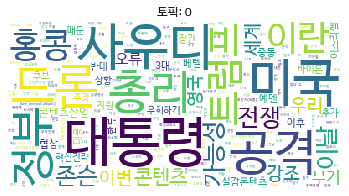

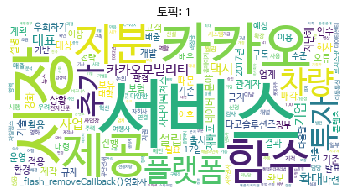

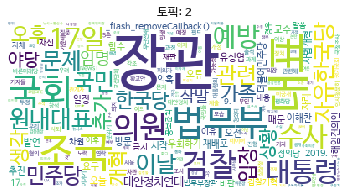

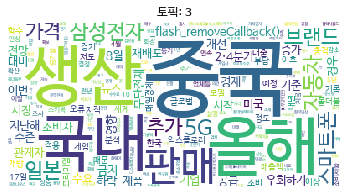

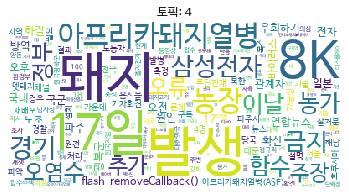

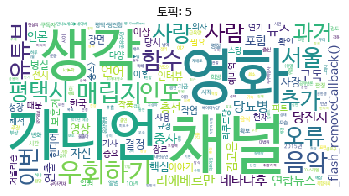

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wc = WordCloud(font_path=r"C:\\Windows\\Fonts\\NanumBarunGothic.ttf", 
               background_color="white")
for k, prob in zip(range(K), Phi):
    p = sorted({v:p for v,p in zip(V, prob)}.items(),
           key=lambda r:r[1], reverse=True)
    wc.generate_from_frequencies(
        {_[0]:_[1] for _ in filter(
            lambda r:r[1] > 0, p)}
        )
    plt.imshow(wc.to_array())
    plt.axis("off")
    plt.title("토픽: "+ str(k))
    plt.show()

문서:  0


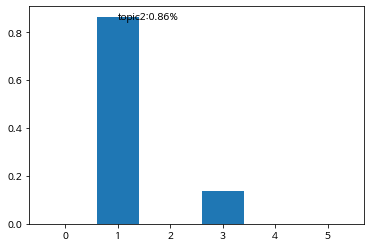

문서:  1


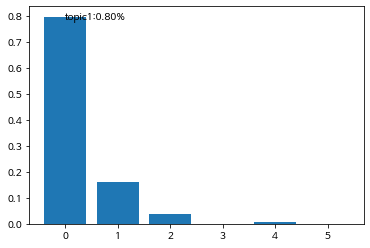

문서:  2


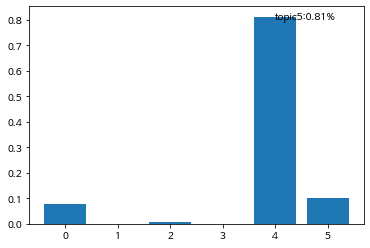

문서:  3


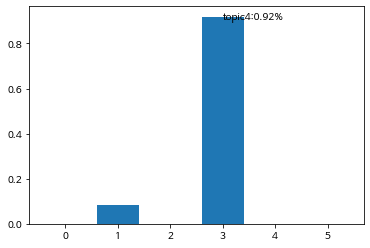

문서:  4


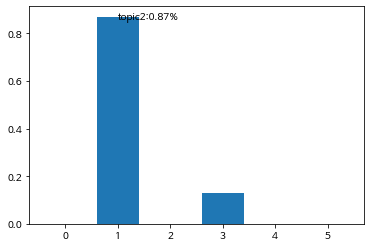

문서:  5


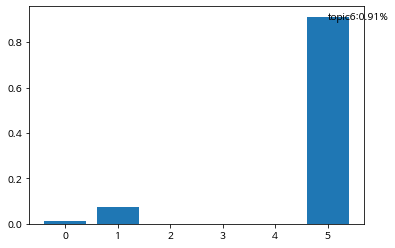

문서:  6


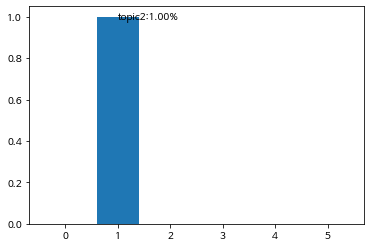

문서:  7


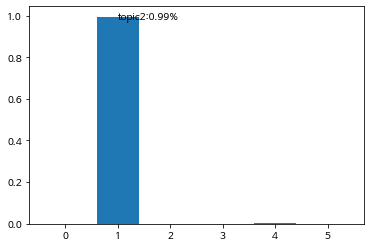

문서:  8


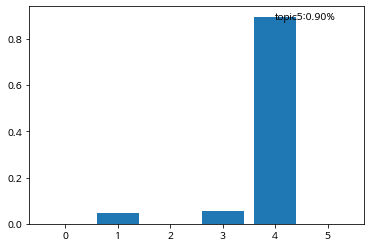

문서:  9


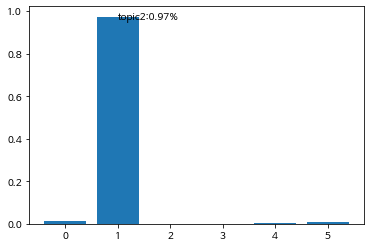

문서:  10


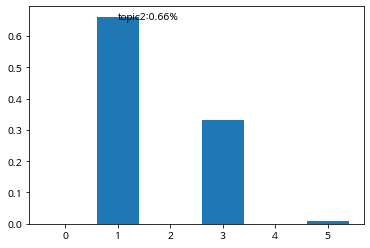

문서:  11


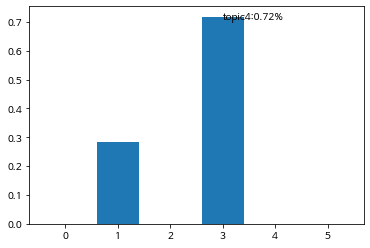

문서:  12


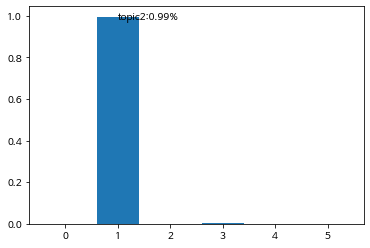

문서:  13


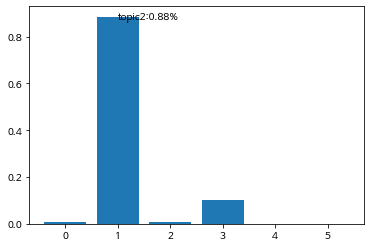

문서:  14


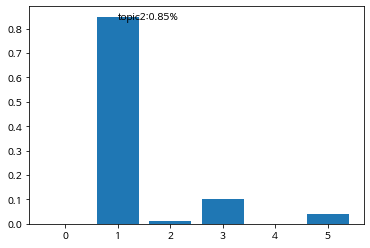

문서:  15


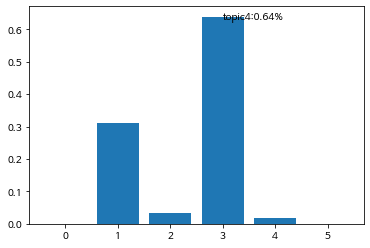

문서:  16


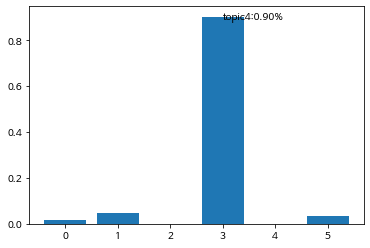

문서:  17


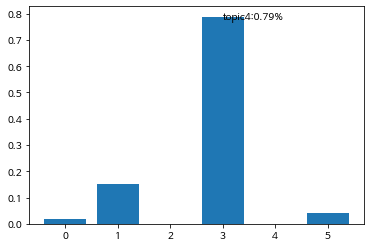

문서:  18


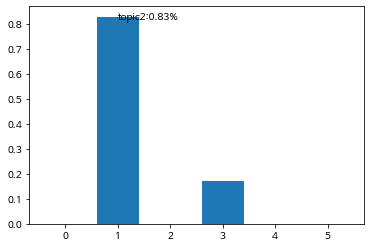

문서:  19


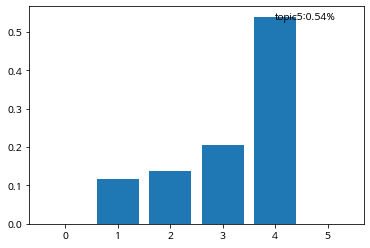

문서:  20


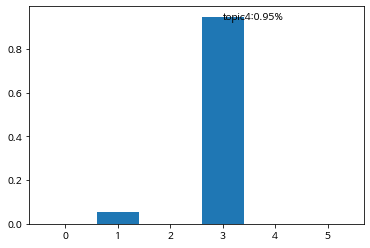

문서:  21


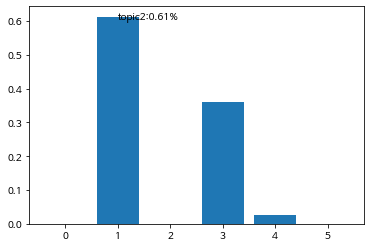

문서:  22


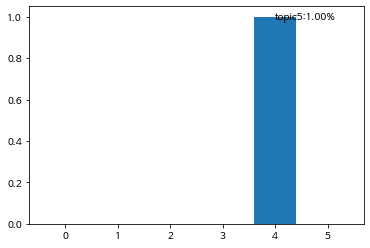

문서:  23


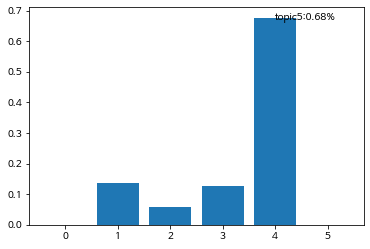

문서:  24


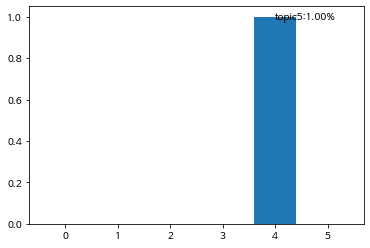

문서:  25


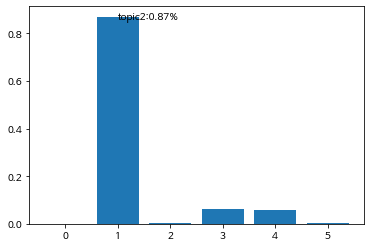

문서:  26


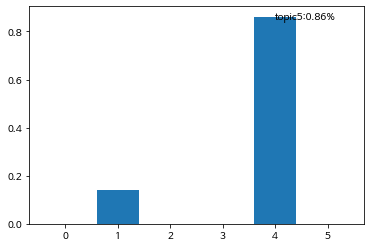

문서:  27


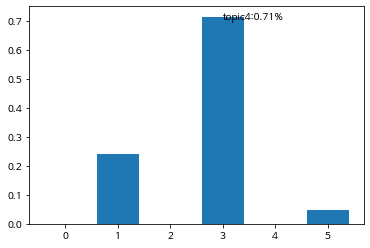

문서:  28


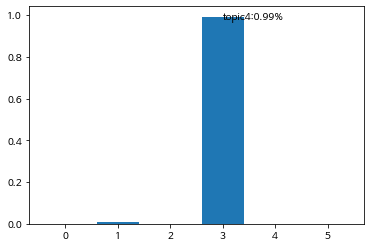

문서:  29


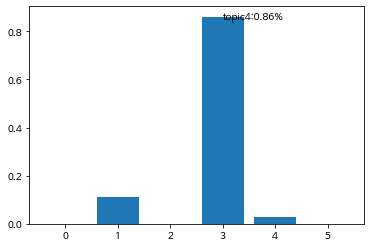

문서:  30


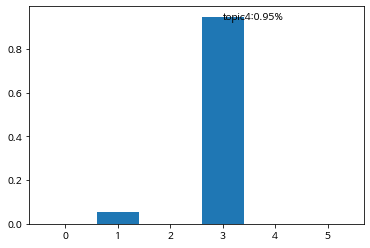

문서:  31


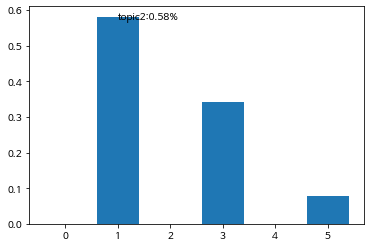

문서:  32


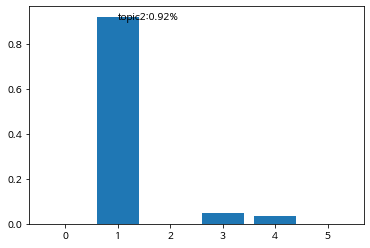

문서:  33


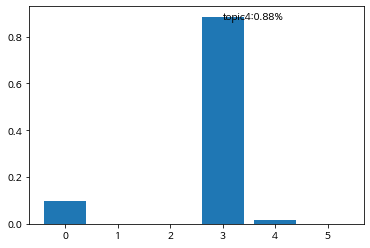

문서:  34


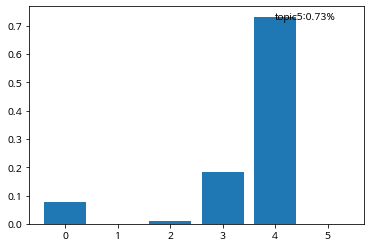

문서:  35


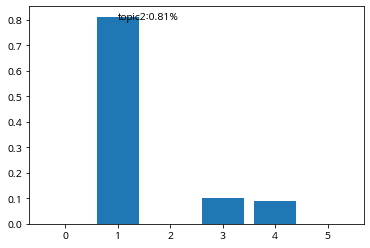

문서:  36


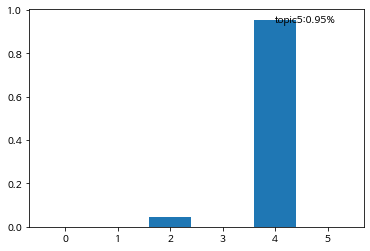

문서:  37


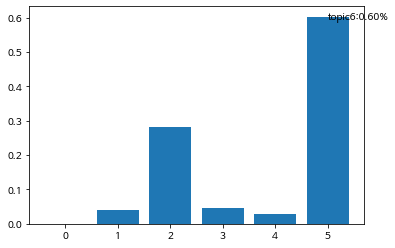

문서:  38


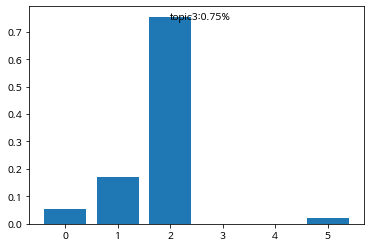

문서:  39


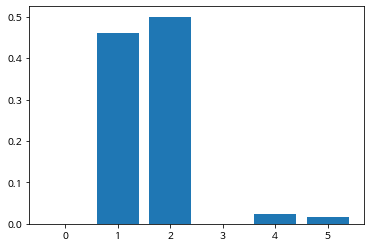

문서:  40


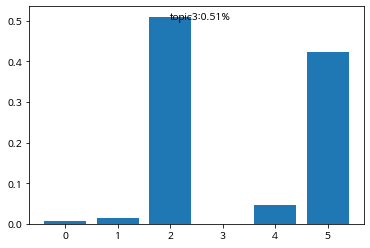

문서:  41


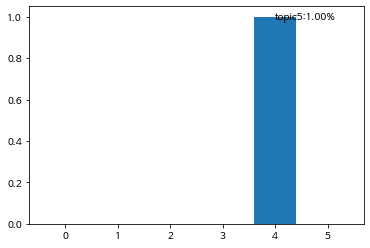

문서:  42


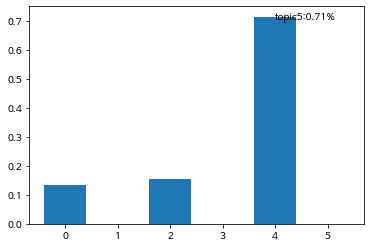

문서:  43


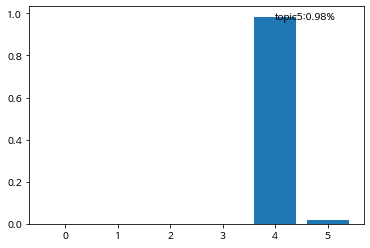

문서:  44


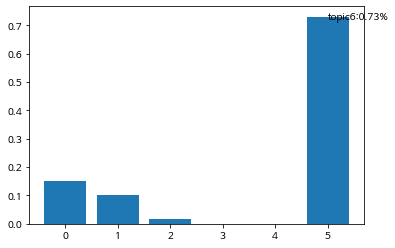

문서:  45


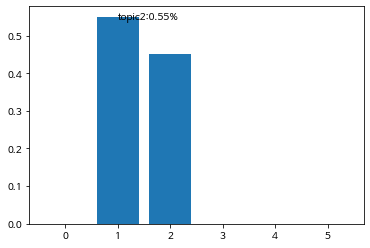

문서:  46


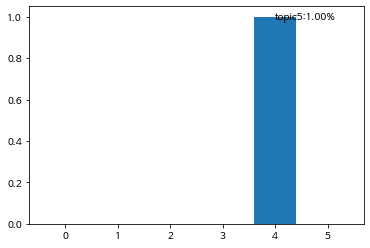

문서:  47


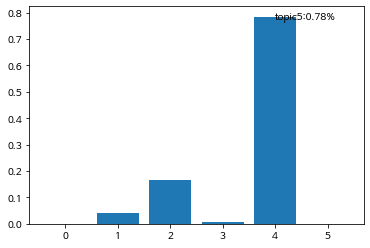

문서:  48


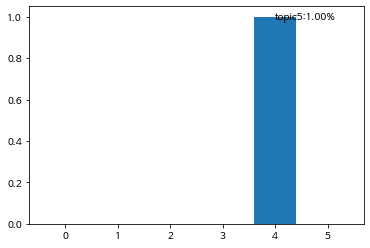

문서:  49


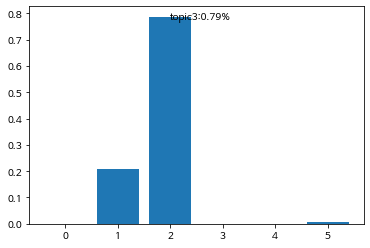

문서:  50


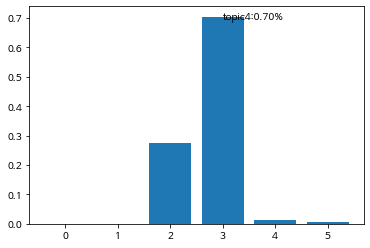

문서:  51


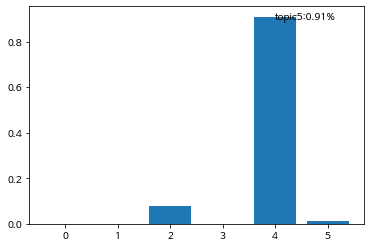

문서:  52


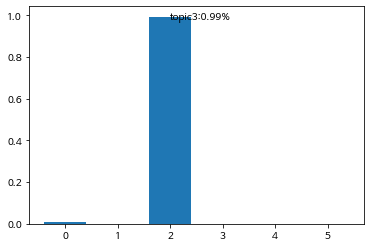

문서:  53


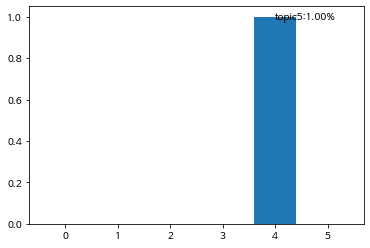

문서:  54


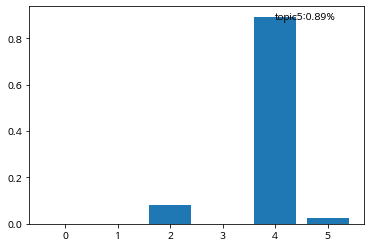

문서:  55


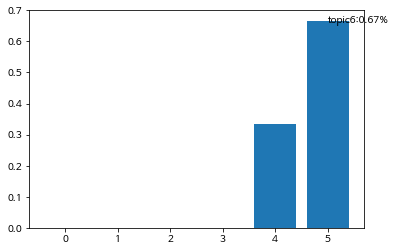

문서:  56


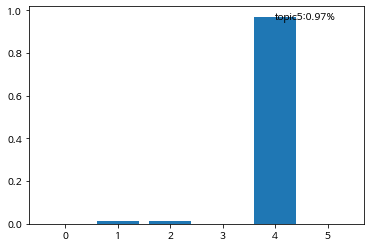

문서:  57


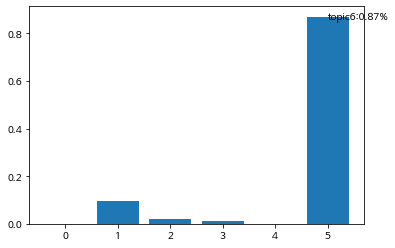

문서:  58


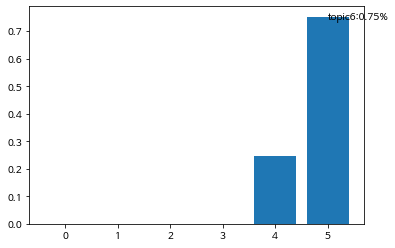

문서:  59


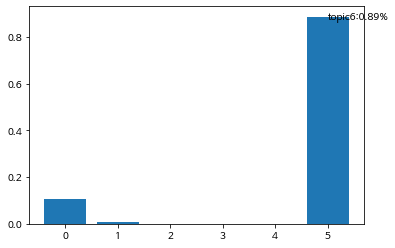

문서:  60


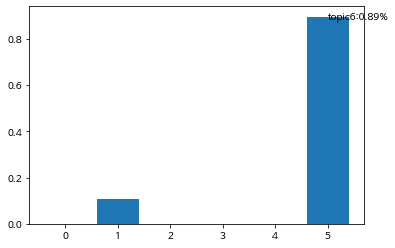

문서:  61


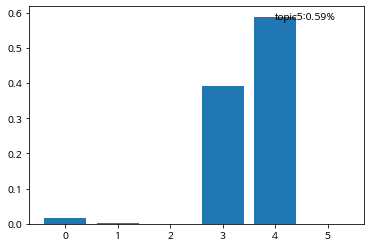

문서:  62


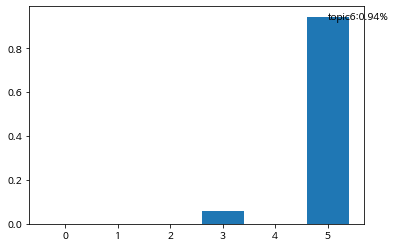

문서:  63


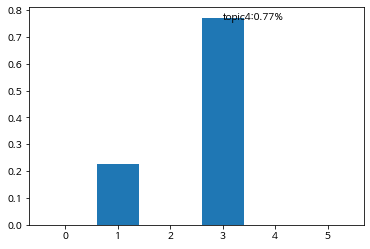

문서:  64


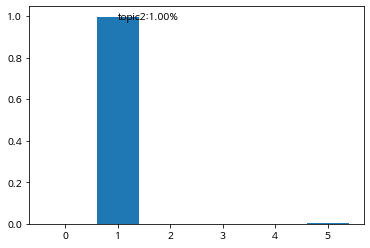

문서:  65


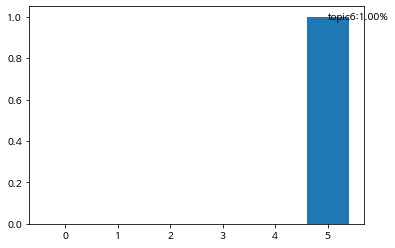

문서:  66


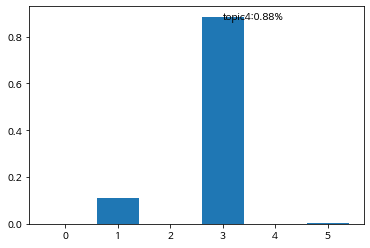

문서:  67


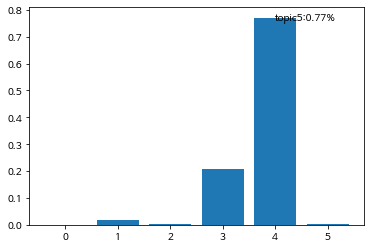

문서:  68


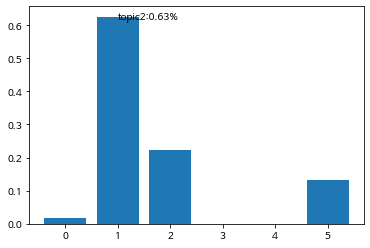

문서:  69


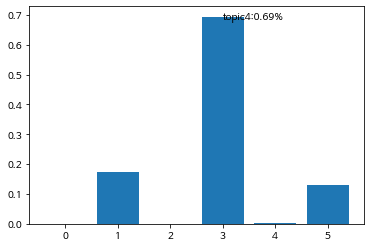

문서:  70


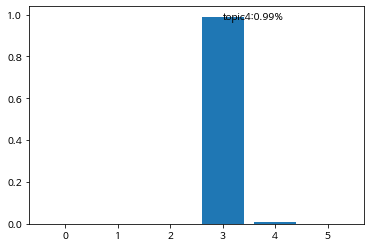

문서:  71


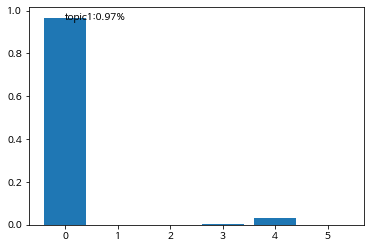

문서:  72


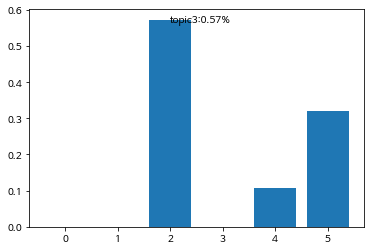

문서:  73


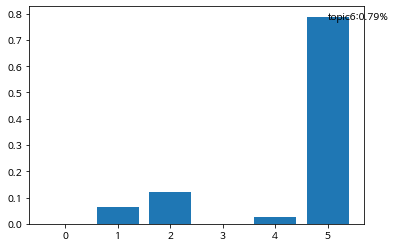

문서:  74


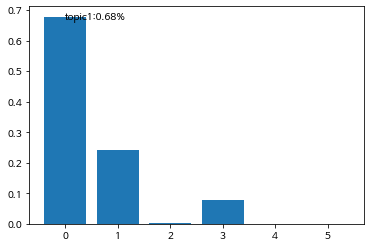

문서:  75


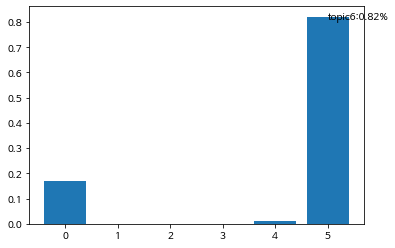

문서:  76


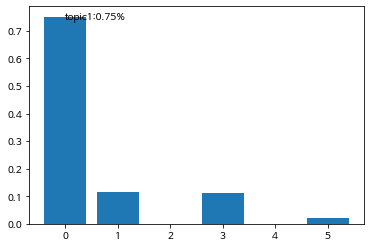

문서:  77


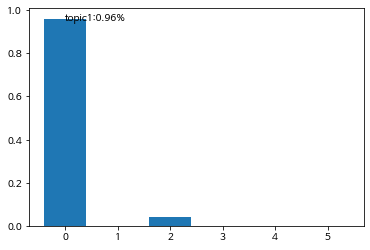

문서:  78


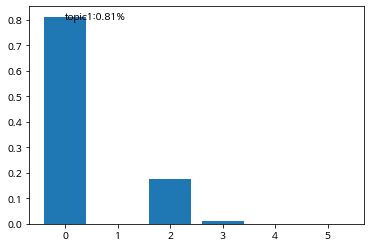

문서:  79


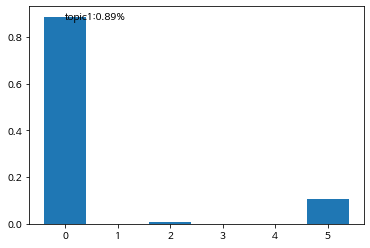

문서:  80


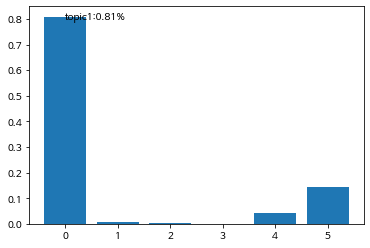

문서:  81


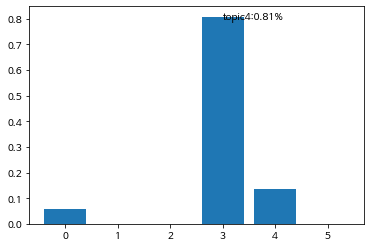

문서:  82


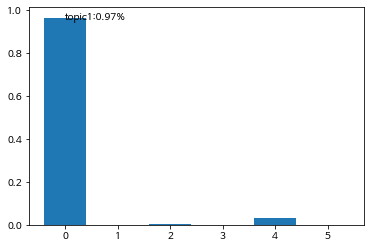

문서:  83


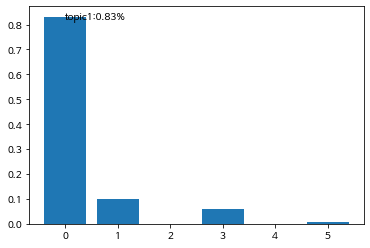

문서:  84


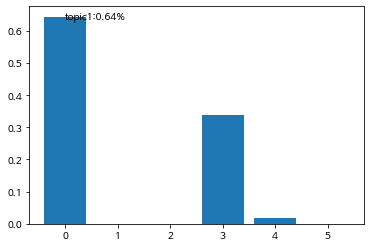

문서:  85


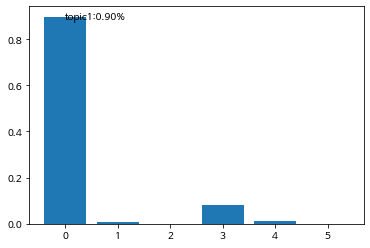

문서:  86


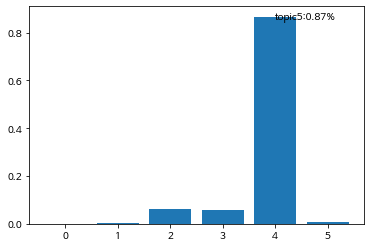

문서:  87


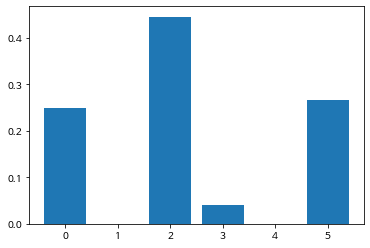

문서:  88


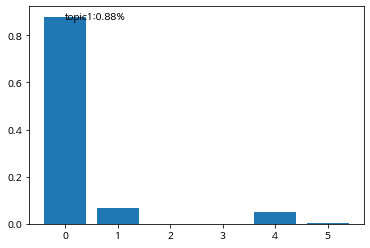

문서:  89


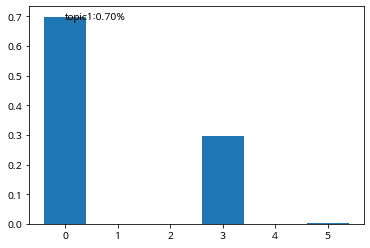

문서:  90


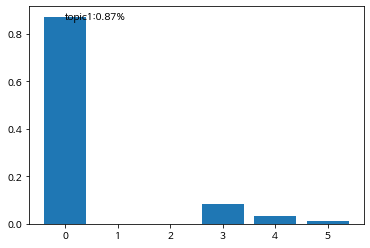

문서:  91


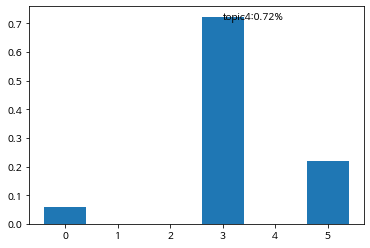

문서:  92


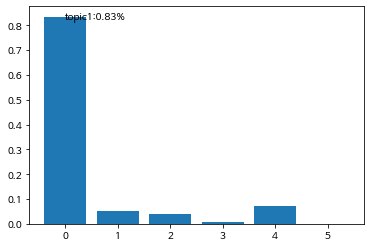

문서:  93


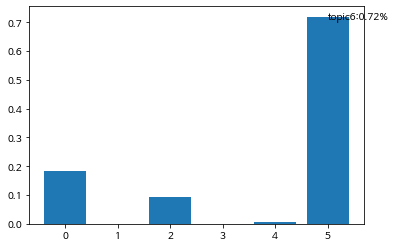

문서:  94


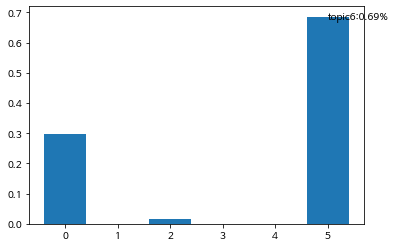

문서:  95


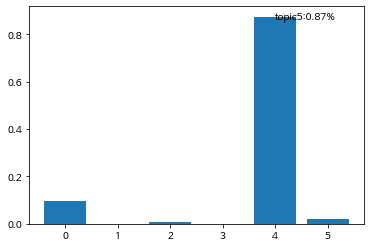

문서:  96


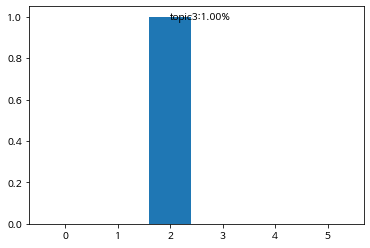

문서:  97


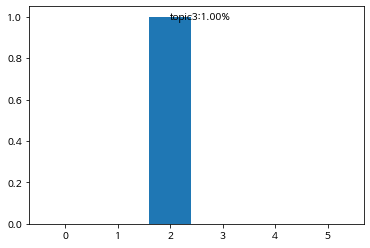

문서:  98


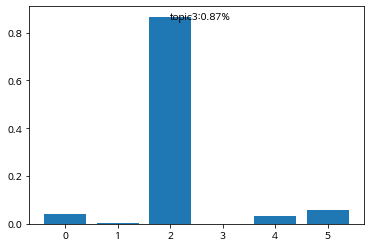

문서:  99


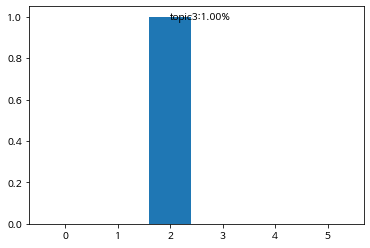

문서:  100


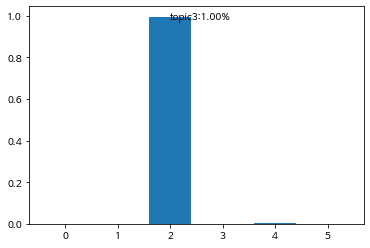

문서:  101


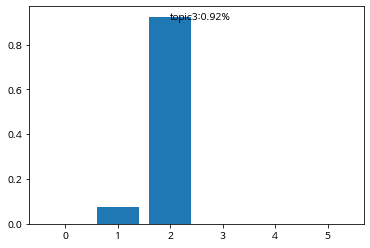

문서:  102


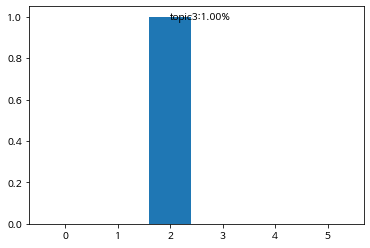

문서:  103


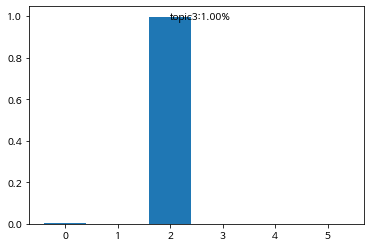

문서:  104


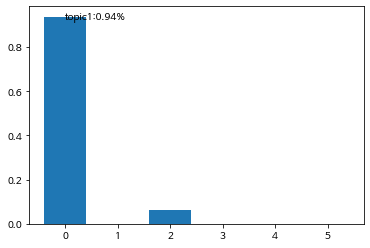

문서:  105


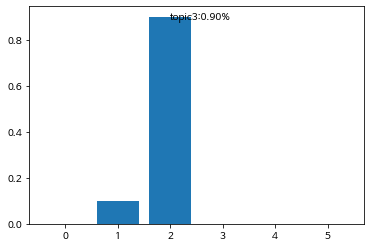

문서:  106


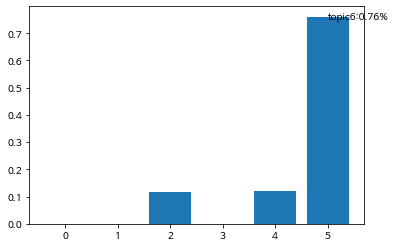

문서:  107


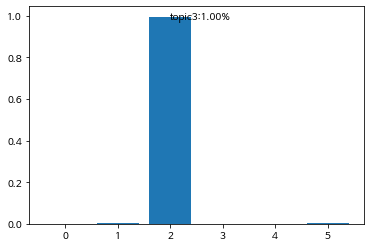

문서:  108


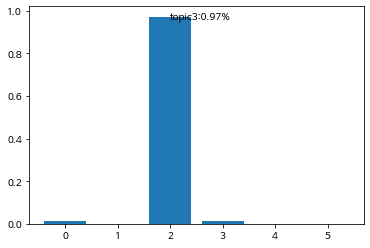

문서:  109


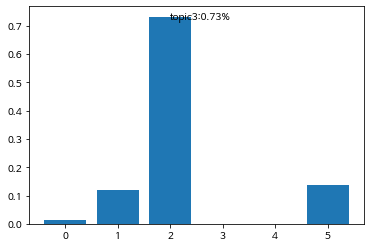

문서:  110


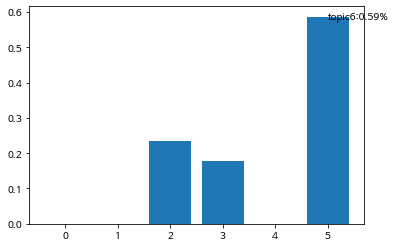

문서:  111


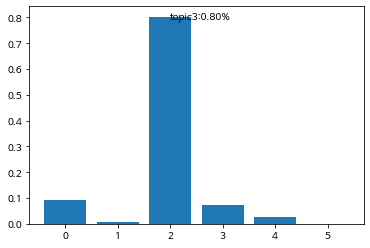

문서:  112


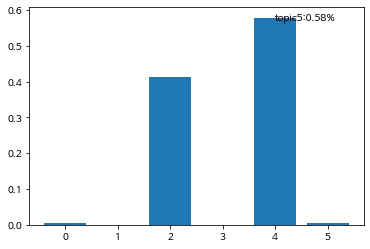

문서:  113


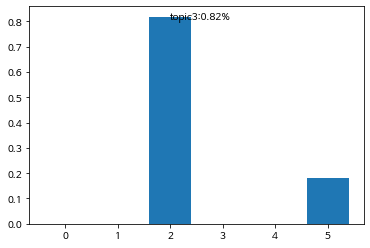

문서:  114


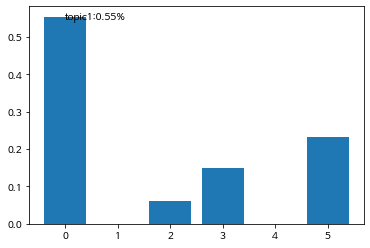

문서:  115


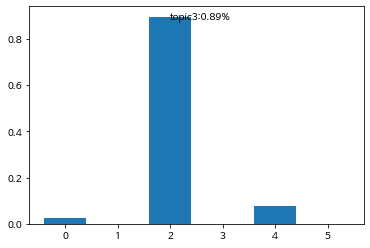

In [73]:
for d, prob in zip(range(M), Theta):
    print("문서: ", d)
    plt.bar(range(K), [p/sum(prob) for p in prob])
    for i, p in enumerate(prob):
        if p/sum(prob) > 0.5:
            plt.text(i, p/sum(prob),
                    "topic{0}:{1:.2f}%".format((i+1), p/sum(prob)),
                    verticalalignment="center")
    plt.show()

토픽:  0


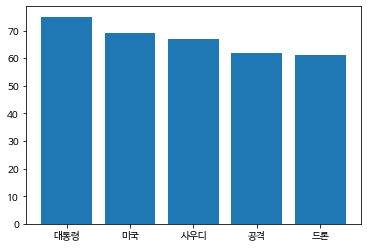

토픽:  1


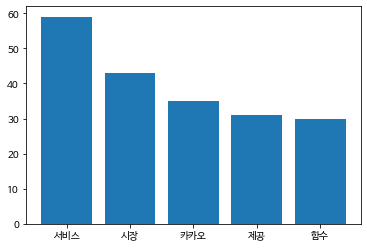

토픽:  2


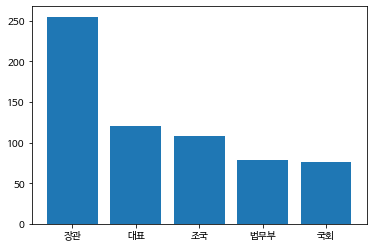

토픽:  3


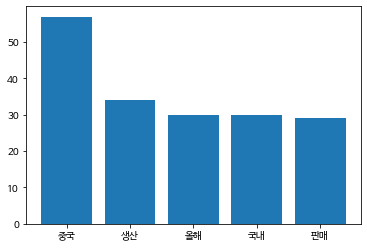

토픽:  4


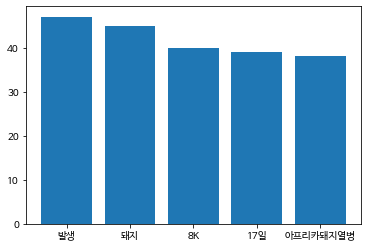

토픽:  5


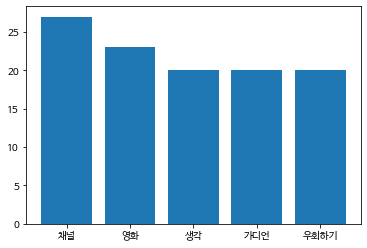

In [84]:
for k, prob in zip(range(K), Phi):
    print("토픽: ", k)
    
    t = sorted({v:p for v,p in zip(V,prob)}.items(),
               key=lambda _:_[1], reverse=True)[:5]
    
    plt.bar(list(map(lambda _:_[0], t)), list(map(lambda _:_[1], t)))
    plt.show()